In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import text

df_final_experiment_clients = pd.read_csv("/content/datafiles/df_final_experiment_clients.txt")

df=pd.read_csv("/content/datafiles/Vanguard_total_data_negs_removed.csv")

In [2]:
df.groupby(by=["iserror","Variation"]).count()

Unnamed: 0  client_id  visitor_id  visit_id  process_step  \
iserror Variation                                                              
False   Control        117284     117284      117284    117284        117284   
        Test           141460     141460      141460    141460        141460   
True    Control         26178      26178       26178     26178         26178   
        Test            36387      36387       36387     36387         36387   

                   date_time  clnt_tenure_yr  clnt_tenure_mnth  clnt_age  \
iserror Variation                                                          
False   Control       117284          117251            117251    117242   
        Test          141460          141411            141411    141411   
True    Control        26178           26169             26169     26166   
        Test           36387           36376             36376     36376   

                    gendr  num_accts     bal  calls_6_mnth  logons_6_mnth  \
iserror Variation                                                           
False   Control    117251     117251  117251        117251         117251   
        Test       141411     141411  141411        141411         141411   
True    Control     26169      26169   26169         26169          26169   
        Test        36376      36376   36376         36376          36376   

                   step_change  time_spent  time_spent_seconds  
iserror Variation                                               
False   Control          85041      117284              117284  
        Test            104256      141460              141460  
True    Control          26178       26178               26178  
        Test             36387       36387               36387

In [3]:
crosstab_result=pd.crosstab(df["iserror"], df["Variation"])
crosstab_result

Variation,Control,Test
iserror,,
False,117284,141460
True,26178,36387


In [4]:
# prompt: do a two-proportion z-test

import statsmodels.api as sm

# Extract the counts from the crosstab
failures = crosstab_result.values[0]  # Number of successes in each group
successes = crosstab_result.values[1]   # Number of failures in each group
nobs = successes + failures

# Perform the two-proportion z-test
z_stat, p_value = sm.stats.proportions_ztest(count=successes, nobs=nobs, alternative='two-sided')

# Print the results
print("Z-statistic:", z_stat)
print("P-value:", p_value)


Z-statistic: -15.743890464833742
P-value: 7.564630625553164e-56


In [5]:
#completion rate step count table
df_counts=pd.DataFrame()

df_counts["client_id"]=df[df["process_step"]==0]["client_id"]
df_counts["step_0"]=True


step_1_clients = df[df["process_step"] == 1]["client_id"].unique()
df_counts['step_1'] = df_counts['client_id'].isin(step_1_clients)

step_2_clients = df[df["process_step"] == 2]["client_id"].unique()
df_counts['step_2'] = df_counts['client_id'].isin(step_2_clients)


step_3_clients = df[df["process_step"] == 3]["client_id"].unique()
df_counts['step_3'] = df_counts['client_id'].isin(step_3_clients)


step_4_clients = df[df["process_step"] == 4]["client_id"].unique()
df_counts['step_4'] = df_counts['client_id'].isin(step_4_clients)


df_counts = df_counts.drop_duplicates(subset=['client_id'])

df_counts=pd.merge(df_counts, df_final_experiment_clients, on="client_id")


In [6]:
df_counts


,client_id,step_0,step_1,step_2,step_3,step_4,Variation
0,169,True,True,True,True,True,NaN
1,555,True,True,True,True,True,Test
2,647,True,True,True,True,True,Test
3,722,True,True,True,True,True,NaN
4,934,True,False,False,False,False,Test
...,...,...,...,...,...,...,...
70009,9999400,True,True,True,True,True,Test
70010,9999626,True,True,False,False,False,Test
70011,9999729,True,True,True,True,True,Test
70012,9999832,True,True,False,False,False,Test


In [7]:
crosstab_result3=pd.crosstab(df_counts["step_4"], df_counts["Variation"])
crosstab_result3

Variation,Control,Test
step_4,,
False,8079,8267
True,15318,18412


In [8]:

# Extract the counts from the crosstab
failures = crosstab_result3.values[0]  # Number of successes in each group
successes = crosstab_result3.values[1]   # Number of failures in each group
nobs = successes + failures

# Perform the two-proportion z-test
z_stat, p_value = sm.stats.proportions_ztest(count=successes, nobs=nobs, alternative='smaller')

# Print the results
print("Z-statistic:", z_stat)
print("P-value:", p_value)


Z-statistic: -8.436362344528874
P-value: 1.63683415137827e-17


In [9]:
current_prop=df_counts[df_counts["Variation"]=="Control"]["step_4"].mean()
desired_proportion=current_prop+0.05

control_group=df_counts[df_counts["Variation"]=="Control"]
# Calculate the number of clients in the test group
n_control = len(control_group)


# Calculate the number of clients that need to change from False to True
num_to_change = int(n_control * desired_proportion) - control_group['step_4'].sum()

if num_to_change > 0:
    # Randomly select clients to change their step_4 value
    clients_to_change = control_group[~control_group['step_4']].sample(n=min(num_to_change, sum(~control_group['step_4'])), random_state=42).index
    # Change the step_4 value for the selected clients
    df_counts.loc[clients_to_change, 'step_4'] = True

# Recalculate the proportion after the change
new_proportion = df_counts[df_counts["Variation"] == "Control"]['step_4'].mean()

print(f"Original proportion of True step_4 values in control group: {current_prop}")
print(f"New proportion of True step_4 values in control group: {new_proportion}")

# ... (Rest of your code) ...



Original proportion of True step_4 values in control group: 0.6546993204256956
New proportion of True step_4 values in control group: 0.7046629909817498


In [10]:
# do a second Z test with 5% better control group:
crosstab_result4=pd.crosstab(df_counts["step_4"], df_counts["Variation"])
crosstab_result4

Variation,Control,Test
step_4,,
False,6910,8267
True,16487,18412


In [11]:
failures = crosstab_result4.values[0]  # Number of successes in each group
successes = crosstab_result4.values[1]   # Number of failures in each group
nobs = successes + failures

# Perform the two-proportion z-test
z_stat, p_value = sm.stats.proportions_ztest(count=successes, nobs=nobs, alternative='smaller')

# Print the results
print("Z-statistic:", z_stat)
print("P-value:", p_value)


Z-statistic: 3.530294055350302
P-value: 0.9997924509813487


In [12]:
#H0: no difference between control group+5% and the test group could be identified

In [13]:
#Last Hypothesis: Number of steps taken per user differs between control and test group


In [14]:
#count the number of steps per client
df_count_per_client=df.groupby(by=["client_id","Variation"]).count()
df_number_test=df_count_per_client.loc[pd.IndexSlice[:, "Test"], "visitor_id"]
df_number_control=df_count_per_client.loc[pd.IndexSlice[:, "Control"], "visitor_id"]

,,visitor_id
client_id,Variation,
555,Test,5
647,Test,5
934,Test,4
1336,Test,7
1346,Test,10
...,...,...
9999150,Test,3
9999400,Test,5
9999626,Test,2


In [15]:
# prompt: do a dual sided t-test on df_number_control and df_number_test

import statsmodels.api as sm

# Assuming df_number_control and df_number_test are pandas Series
# Perform the two-sample t-test
t_stat, p_value, df_t = sm.stats.ttest_ind(df_number_control, df_number_test, alternative='two-sided')

# Print the results
print("T-statistic:", t_stat)
print("P-value:", p_value)
print("Degrees of freedom:", df_t)


T-statistic: -13.32150536859316
P-value: 2.0313876507347403e-40
Degrees of freedom: 50498.0


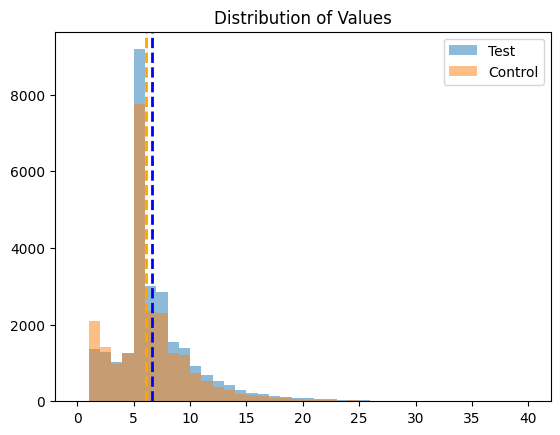

In [33]:
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.hist(df_number_test, bins=40, range=(0,40), alpha=0.5, label='Test')
plt.hist(df_number_control, bins=40, range=(0,40), alpha=0.5, label='Control')
plt.legend(loc='upper right')
plt.title('Distribution of Values')
avg_test=df_number_test.mean()
avg_control=df_number_control.mean()

# Add vertical lines for the average values
plt.axvline(avg_test, color='blue', linestyle='dashed', linewidth=2, label=f'Test Avg: {avg_test:.2f}')
plt.axvline(avg_control, color='orange', linestyle='dashed', linewidth=2, label=f'Control Avg: {avg_control:.2f}')

plt.show()


In [17]:
from scipy.stats import mannwhitneyu

# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(df_number_test, df_number_control, alternative='two-sided')

print("Mann-Whitney U statistic:", statistic)
print("P-value:", p_value)

Mann-Whitney U statistic: 342989601.5
P-value: 5.7628232469101135e-58


In [34]:
avg_test

6.594741916345298

In [35]:
avg_control


6.096464388917219